In [1]:
# import pandas as pd
# pd.set_option("display.max_columns", None)
# from IPython.display import HTML
# from IPython.display import display
# import numpy as np
# import warnings
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
# warnings.simplefilter(action="ignore", category=FutureWarning)
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os

# from scipy.optimize import curve_fit

# from sklearn import preprocessing
# from sklearn import metrics
# os.chdir("..")
# os.getcwd()


'c:\\Users\\tmueh\\Documents\\GitHub\\training_dataset_size_per_class'

In [2]:
#from platform import python_version
#python_version()


'3.8.10'

In [ ]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics
os.chdir("..")
os.getcwd()

from platform import python_version
print(python_version())

import importlib.util

spec = importlib.util.spec_from_file_location("data_pred", "src\\data_prep.py")
prep_data = importlib.util.module_from_spec(spec)
spec.loader.exec_module(prep_data)
prep_data.hello_world()

### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using Cifar10 data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### power law: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [3]:
#results = pd.read_csv("Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_20230628.csv")
results = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_20230705.csv")
results_val = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_val_20230708.csv")
results_4500 = pd.read_csv("csv_files/Cifar10_acc_subsets_jelena_batch_size_512_mixture_design_maximin_subsetsize_4500_20230715.csv")
print(results.shape)
print(results_4500.shape)
results.head(2)

(10800, 13)
(12000, 14)


,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained
0,0.1006,0.868126,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,0
1,0.1314,4.390345,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,5


In [4]:
results_4500.head(3)

,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained
0,0,0.4069,19.104083,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,0
1,0,0.6214,94.780431,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,5
2,0,0.7134,95.816427,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,10


In [5]:
# Filter data to start with 10 epochs:
# anything below a certain number of epochs seems to be very flaky.
min_epoch = 20
mask = results.epochs_trained >= min_epoch
results = results[mask].reset_index(drop=True)
mask = results_val.epochs_trained >= min_epoch
results_val = results_val[mask].reset_index(drop=True)
mask = results_4500.epochs_trained >= min_epoch
results_4500 = results_4500[mask].reset_index(drop=True)

In [6]:
classes = results.columns.tolist()[2:12]
print(classes)
results["total_training_size"] = results[classes].sum(axis=1)
results_val["total_training_size"] = results_val[classes].sum(axis=1)
results.head(4)


['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.2030,4.387133,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,20,4999.0
1,0.2506,4.299767,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,25,4999.0
2,0.2437,4.289541,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,30,4999.0
3,0.2550,4.428070,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,35,4999.0


In [7]:
results_4500["total_training_size"] = results_4500[classes].sum(axis=1)
results_4500.head(4)


,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0


In [8]:
# print out first few rows of generated dataset:
print(results[["accs"] + classes + ["epochs_trained", "total_training_size"]].iloc[:5, :].to_latex(float_format="{:.2f}".format))


\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &  accs &  plane &   car &  bird &    cat &    deer &    dog &    frog &  horse &   ship &  truck &  epochs\_trained &  total\_training\_size \\
\midrule
0 &  0.20 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              20 &              4999.00 \\
1 &  0.25 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              25 &              4999.00 \\
2 &  0.24 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              30 &              4999.00 \\
3 &  0.26 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              35 &              4999.00 \\
4 &  0.29 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              40 &              4999.00 \\
\bottomrule
\end{tabular}



In [9]:
### constructing a pred dataset: 
results_pred = results[["training_times"] + classes + ["epochs_trained", "total_training_size"]].copy()
row = {c: 5000 for c in classes}
row["epochs_trained"] = 195
row["total_training_size"] =  50000
row["training_times"] = 100
results_pred = results_pred.append(row, ignore_index=True)
row = {c: 5000 for c in classes}
row["training_times"] = 100
row["epochs_trained"] = 150
row["total_training_size"] =  50000
results_pred = results_pred.append(row, ignore_index=True)
results_pred = results_pred.iloc[-2:,:].reset_index(drop=True)
for c_5000 in classes:
    row = {c: 4500 for c in classes}
    row[c_5000] = 5000
    row["epochs_trained"] = 195
    row["training_times"] = 100
    row["total_training_size"] =  45500
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 150
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 100
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)
for c_5000 in classes:
    row = {c: 4000 for c in classes}
    row[c_5000] = 5000
    row["epochs_trained"] = 195
    row["training_times"] = 100
    row["total_training_size"] =  41000
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 150
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 100
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)
for c_5000 in classes:
    row = {c: 5000 for c in classes}
    row[c_5000] = 7000
    row["epochs_trained"] = 195
    row["training_times"] = 100
    row["total_training_size"] =  52000
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 150
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 100
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)

results_pred_orig = results_pred.copy()
results_pred

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0


In [10]:
### normalize results for train:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X = results.iloc[:, 1:])
results_scaled = pd.DataFrame(scaler.transform(results.iloc[:, 1:]))
results_scaled.columns = results.iloc[:, 1:].columns
results = pd.concat([results["accs"], results_scaled], axis=1)
results.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.2030,0.004924,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.000000,0.000025
1,0.2506,0.001595,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.028571,0.000025


In [11]:
# using the same scaler for val:
results_scaled_val = pd.DataFrame(scaler.transform(results_val.iloc[:, 1:]))
results_scaled_val.columns = results_val.iloc[:, 1:].columns
results_val = pd.concat([results_val["accs"], results_scaled_val], axis=1)
results_val.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.3246,0.008338,0.138187,0.041833,0.040706,0.005404,0.15016,0.019832,0.395143,0.038223,0.151521,0.008002,0.000000,0.0001
1,0.3468,0.004590,0.138187,0.041833,0.040706,0.005404,0.15016,0.019832,0.395143,0.038223,0.151521,0.008002,0.028571,0.0001


In [12]:
#results_4500.head()
#tmp = results_pred.merge(results_4500, on = classes + ["epochs_trained", "total_training_size"], how = "inner")


In [13]:
results_pred.head()

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0


In [14]:
# using the same scaler for pred tries:
results_scaled_pred = pd.DataFrame(scaler.transform(results_pred))
results_scaled_pred.columns = results_pred.columns
results_pred = results_scaled_pred
results_pred

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.00000,1.000000,1.124881
1,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.00000,0.742857,1.124881
2,3.648453,1.000201,0.90012,0.899940,0.90012,0.900160,0.90004,0.899860,0.90034,0.90012,0.89998,1.000000,1.012398
3,3.648453,1.000201,0.90012,0.899940,0.90012,0.900160,0.90004,0.899860,0.90034,0.90012,0.89998,0.742857,1.012398
4,3.648453,1.000201,0.90012,0.899940,0.90012,0.900160,0.90004,0.899860,0.90034,0.90012,0.89998,0.457143,1.012398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.40052,1.00000,0.171429,1.174874
118,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.40008,1.000000,1.174874
119,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.40008,0.742857,1.174874
120,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.40008,0.457143,1.174874


In [15]:
results_4500.head(2)

,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0


In [16]:
results_4500_orig = results_4500.copy()
results_scaled_4500 = pd.DataFrame(scaler.transform(results_4500.iloc[:, 2:]))
results_scaled_4500.columns = results_4500.iloc[:, 2:].columns
#results_4500 = results_4500_scaled
#results_4500.head(3)
results_4500 = pd.concat([results_4500["accs"], results_scaled_4500], axis=1)
results_4500.head(2)


,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.7703,3.472672,1.000201,0.90012,0.89994,0.90012,0.90016,0.90004,0.89986,0.90034,0.90012,0.89998,0.000000,1.012398
1,0.7833,3.461482,1.000201,0.90012,0.89994,0.90012,0.90016,0.90004,0.89986,0.90034,0.90012,0.89998,0.028571,1.012398


In [17]:
results_4500["class"] = results_4500[classes].idxmax(axis=1)
results_4500.head(2)
# continue from here

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,class
0,0.7703,3.472672,1.000201,0.90012,0.89994,0.90012,0.90016,0.90004,0.89986,0.90034,0.90012,0.89998,0.000000,1.012398,plane
1,0.7833,3.461482,1.000201,0.90012,0.89994,0.90012,0.90016,0.90004,0.89986,0.90034,0.90012,0.89998,0.028571,1.012398,plane


In [18]:
# prep data for using class counts:
xdata = np.transpose(results.to_numpy()[:, 2:-1])
y = results.to_numpy()[:, 0]
xdata_val = np.transpose(results_val.to_numpy()[:, 2:-1])
y_val = results_val.to_numpy()[:, 0]
xdata.shape
xpred = np.transpose(results_pred.to_numpy()[:, 1:-1])
xpred.shape


(11, 122)

In [19]:
xdata.shape

(11, 9720)

In [20]:
#display(results_4500.head(2))
display(results_4500_orig.head())
xdata_4500 = np.transpose(results_4500.loc[:, classes + ["epochs_trained"] ].to_numpy())
print(xdata_4500.shape)
#xdata_4500
results_4500.head(2)
y_4500 = results_4500.to_numpy()[:, 0]
display(results_4500_orig.head())


,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


(11, 10800)


,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


In [21]:
# data for last_epoch_training:
mask = results.epochs_trained == 1
results_last_epoch = results[mask].reset_index(drop=True)
xdata_last_epoch = np.transpose(results_last_epoch.to_numpy()[:, 2:-2])
y_last_epoch = results_last_epoch.to_numpy()[:, 0]

mask = results_val.epochs_trained == 1
results_val_last_epoch = results_val[mask].reset_index(drop=True)
xdata_val_last_epoch = np.transpose(results_val_last_epoch.to_numpy()[:, 2:-2])
y_val_last_epoch = results_val_last_epoch.to_numpy()[:, 0]

In [22]:
# data for total_n and epoch only:
xdata_total_n_epoch = np.transpose(results.to_numpy()[:, -2:])
xdata_val_total_n_epoch = np.transpose(results_val.to_numpy()[:, -2:])
xpred_total_n_epoch = np.transpose(results_pred.to_numpy()[:, -2:])
xpred_total_n_epoch.shape

(2, 122)

In [23]:
# data for last epoch, total_n only:
xdata_last_epoch_total_n = np.transpose(results_last_epoch.to_numpy()[:, -1:])
xdata_val_last_epoch_total_n = np.transpose(results_val_last_epoch.to_numpy()[:, -1:])
xdata_last_epoch_total_n.shape

(1, 270)

In [24]:
# some plotting parameters
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# powerlaw - full linear option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch
param_value,-0.028546,0.381403,0.455502,0.658278,0.525164,0.516432,0.281976,0.522926,0.472828,0.50151,0.64134,0.380966,0.4241,0.669978


\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch \\
\midrule
param\_value & -0.03 & 0.38 & 0.46 &   0.66 & 0.53 &  0.52 & 0.28 &  0.52 & 0.47 &  0.50 &   0.64 &  0.38 &   0.42 &   0.67 \\
\bottomrule
\end{tabular}

0.002005015466091406


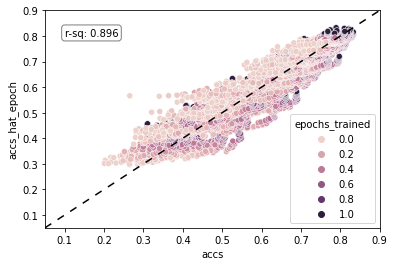

0.8958535485189698
mean val loss: 0.0021504284525420865


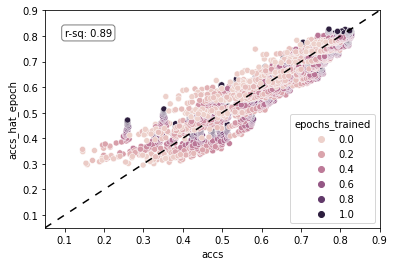

r_square val: 0.8896818108862111


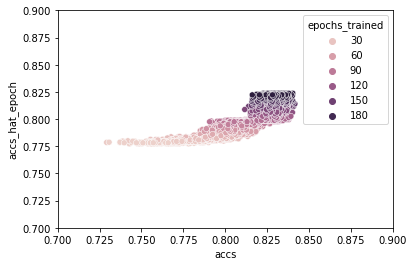

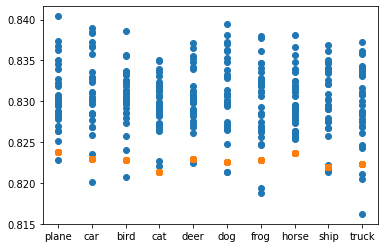

In [25]:
def func_powerlaw(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c

np.random.seed(seed=4213523)
p0 = np.random.uniform(low=0, high=1, size = 14)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c"]
    param_names = param_names + classes + ["epoch"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_epoch"
    y_hat = func_powerlaw(xdata, *params)
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat

    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val, *params)
    print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()

    print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")
    
    acc_4500 = func_powerlaw(xdata_4500, *params)
    results_4500[y_hat_name] = acc_4500
    results_4500_orig[y_hat_name] = acc_4500

    sns.scatterplot(data = results_4500_orig, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.7, 0.9))
    plt.ylim((0.7, 0.9))
    #plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    #plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_4500.accs, results_4500[y_hat_name]), 3)}", bbox=props)
    #plt.savefig(f"paper/plots/powerlaw_4500_{y_hat_name}.jpg")
    plt.show()
    results_4500.head(2)

    mask = results_4500_orig.epochs_trained == 195
    plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask]["accs"], label= "accs")
    plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask][y_hat_name], label= "accs pred")
    #sns.scatterplot(data = results_4500[mask], x="class", y = "accs", hue = "epochs_trained")
    #plt.xlim((0.7, 0.9))
    #plt.ylim((0.7, 0.9))
    #plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    #plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_4500.accs, results_4500[y_hat_name]), 3)}", bbox=props)
    #plt.savefig(f"paper/plots/powerlaw_4500_{y_hat_name}.jpg")
    plt.show()
    results_4500_orig.head(2)


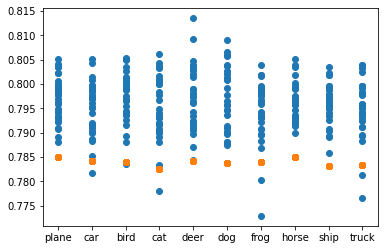

In [26]:

mask = results_4500_orig.epochs_trained == 40
plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask]["accs"], label= "accs")
plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask][y_hat_name], label= "accs pred")
plt.show()


### Using an arctan effect for epoch only, but linear for classes:

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch_2
param_value,-0.279471,0.319458,0.530418,1.167697,0.948285,0.923937,0.515567,0.942888,0.844816,0.903454,1.151387,0.690578,0.763358,1.104789,7.240699


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch\_2 \\
\midrule
param\_value & -0.28 & 0.32 & 0.53 &   1.17 & 0.95 &  0.92 & 0.52 &  0.94 & 0.84 &  0.90 &   1.15 &  0.69 &   0.76 &   1.10 &     7.24 \\
\bottomrule
\end{tabular}

0.001779158225500692


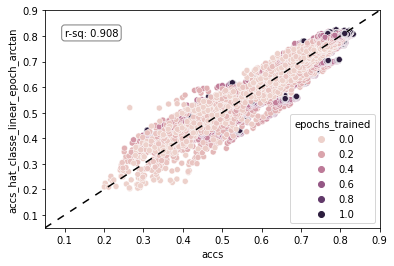

0.9075852436338582
mean val loss: 0.0019092461231990329


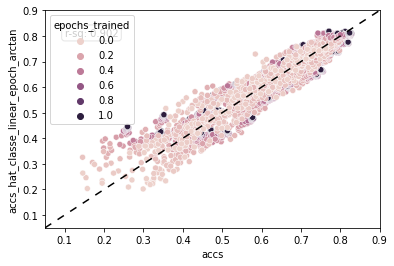

r_square val: 0.9020546000333778


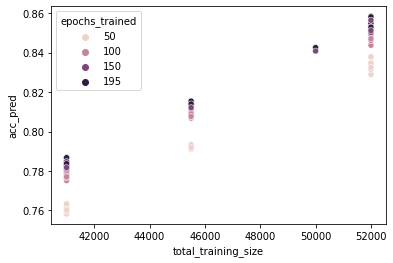

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.842601
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.840831
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.815480
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.813614
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.809200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.831454
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.852986
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.851251
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.847145


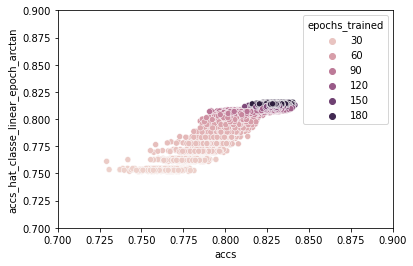

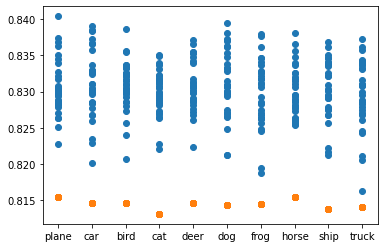

In [27]:
def func_powerlaw(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**b) * c

np.random.seed(seed=42135230)
p0 = np.random.uniform(low=0, high=1, size = 15)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")


if converged:
    param_names = ["a", "b", "c"]
    param_names = param_names + classes + ["epoch", "epoch_2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_classe_linear_epoch_arctan"
    y_hat = func_powerlaw(xdata, *params)
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat

    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val, *params)
    print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()

    print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig)
    
    acc_4500 = func_powerlaw(xdata_4500, *params)
    results_4500[y_hat_name] = acc_4500
    results_4500_orig[y_hat_name] = acc_4500

    sns.scatterplot(data = results_4500_orig, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.7, 0.9))
    plt.ylim((0.7, 0.9))
    plt.show()
    results_4500.head(2)

    mask = results_4500_orig.epochs_trained == 195
    plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask]["accs"], label= "accs")
    plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask][y_hat_name], label= "accs pred")
    plt.show()
    results_4500_orig.head(2)
    
    

### using an arctan effect for every class:

param_name,a,b,c,plane_1,plane_2,car_1,car_2,bird_1,bird_2,cat_1,cat_2,deer_1,deer_2,dog_1,dog_2,frog_1,frog_2,horse_1,horse_2,ship_1,ship_2,truck_1,truck_2,epoch_1,epoch_2
param_value,0.151507,1.383827,0.022337,0.736557,9.543433,0.833636,15.662806,0.662435,7.414664,0.447738,6.138,0.700804,4.030193,0.56486,5.308396,0.736686,10.231103,0.837716,12.558595,0.796032,17.630621,0.716979,17.850267,1.062883,8.695603


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &  plane\_1 &  plane\_2 &  car\_1 &  car\_2 &  bird\_1 &  bird\_2 &  cat\_1 &  cat\_2 &  deer\_1 &  deer\_2 &  dog\_1 &  dog\_2 &  frog\_1 &  frog\_2 &  horse\_1 &  horse\_2 &  ship\_1 &  ship\_2 &  truck\_1 &  truck\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\_value & 0.15 & 1.38 & 0.02 &     0.74 &     9.54 &   0.83 &  15.66 &    0.66 &    7.41 &   0.45 &   6.14 &    0.70 &    4.03 &   0.56 &   5.31 &    0.74 &   10.23 &     0.84 &    12.56 &    0.80 &   17.63 &     0.72 &    17.85 &     1.06 &     8.70 \\
\bottomrule
\end{tabular}

0.00050135114234363


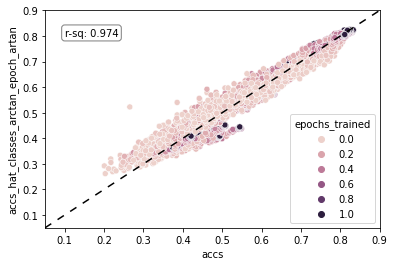

0.9739583343350282
0.9738911750982194
mean val loss: 0.0005784586323472864


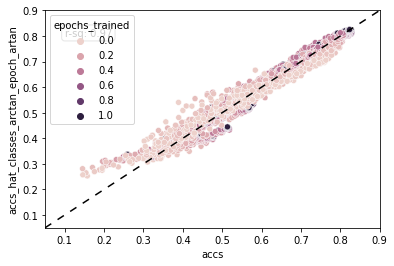

r_square val: 0.9703247468092442
0.9701712752888121


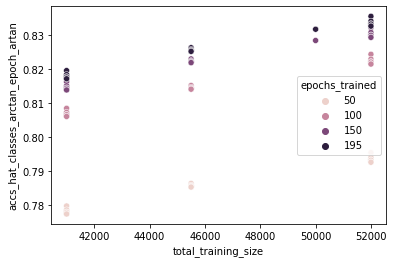

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred,accs_hat_classes_arctan_epoch_artan
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.842601,0.831677
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.840831,0.828367
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.815480,0.825484
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.813614,0.822182
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.809200,0.814357
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.793387,0.785554
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.814676,0.825277
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.812808,0.821975
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.808386,0.814150
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.792548,0.785350


param_value           
param_no           1          2
feature                        
bird        0.662435   7.414664
car         0.833636  15.662806
cat         0.447738   6.138000
deer        0.700804   4.030193
dog         0.564860   5.308396
epoch       1.062883   8.695603
frog        0.736686  10.231103
horse       0.837716  12.558595
plane       0.736557   9.543433
ship        0.796032  17.630621
truck       0.716979  17.850267

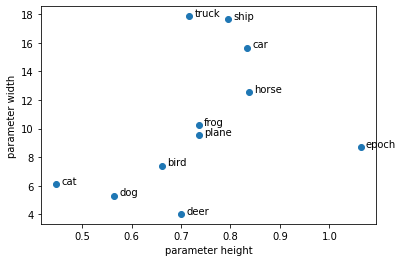

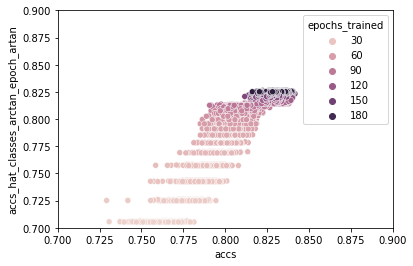

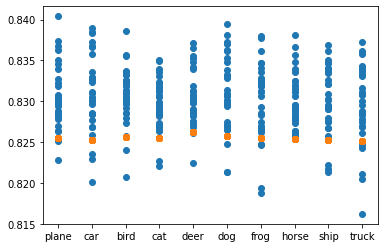

In [28]:
def func_powerlaw(x, a: float, b: float, c: float, d0:float, d0_2:float, d1:float, d1_2:float, d2:float, d2_2:float, d3:float, d3_2:float, d4:float, d4_2:float, d5:float, d5_2:float, d6:float, d6_2:float, d7:float, d7_2:float, d8:float, d8_2:float, d9:float, d9_2:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**b) * c

np.random.seed(seed=42135230)
n_p = 25
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 50))
    converged = True
except:
    print("did not converge")


if converged:
    param_names = ["a", "b", "c"]
    for c in classes:
        param_names = param_names + [f"{c}_1", f"{c}_2"]
    param_names = param_names + ["epoch_1", "epoch_2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_classes_arctan_epoch_artan"
    y_hat = func_powerlaw(xdata, *params)
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat

    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results.accs, results[y_hat_name])) * (xdata.shape[1] - 1) / (xdata.shape[1] - n_p - 1))
    # val data:
    y_val_hat = func_powerlaw(xdata_val, *params)
    print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()

    print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")
    print(1 - (1 - metrics.r2_score(results_val.accs, results_val[y_hat_name])) * (xdata_val.shape[1] - 1) / (xdata_val.shape[1] - n_p - 1))
    # Doing different prediction scenarios for accuracy:

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig[y_hat_name] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = y_hat_name, hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))
    #param_df.T.reset_index(drop=False).iloc[3:,:]
    param_unstacked = param_df.T.reset_index(drop=False).iloc[3:,:].param_name.str.split("_", expand=True).reset_index(drop=True)
    param_unstacked.columns = ["feature", "param_no"]
    param_unstacked["param_value"] = param_df.T.reset_index(drop=False).iloc[3:,:].reset_index(drop=True).param_value
    param_unstacked = param_unstacked.set_index(["feature", "param_no"])
    param_unstacked = param_unstacked.unstack()
    display(param_unstacked)

    param_unstacked.iloc[:,1]
    plt.scatter(param_unstacked.iloc[:,0], param_unstacked.iloc[:,1])
    plt.xlabel("parameter height")
    plt.ylabel("parameter width")
    for i in range(param_unstacked.shape[0]):
        plt.annotate(param_unstacked.reset_index().iloc[i,0], (param_unstacked.iloc[i,0] + 0.01, param_unstacked.iloc[i, 1]))
    plt.savefig(f"paper/plots/powerlaw_{y_hat_name}_param1_vs_param2.jpg")
    plt.show()
        
    acc_4500 = func_powerlaw(xdata_4500, *params)
    results_4500[y_hat_name] = acc_4500
    results_4500_orig[y_hat_name] = acc_4500

    sns.scatterplot(data = results_4500_orig, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.7, 0.9))
    plt.ylim((0.7, 0.9))
    plt.show()
    results_4500.head(2)

    mask = results_4500_orig.epochs_trained == 195
    plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask]["accs"], label= "accs")
    plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask][y_hat_name], label= "accs pred")
    plt.show()
    results_4500_orig.head(2)



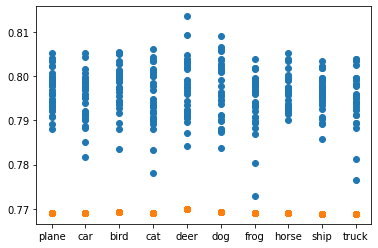

In [29]:

mask = results_4500_orig.epochs_trained == 40
plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask]["accs"], label= "accs")
plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask][y_hat_name], label= "accs pred")
plt.show()


In [30]:
# # the following would be an even strong generalization, however, this does not provide actual benefits in fitting (but takes around 11 minutes to fit)

# def func_powerlaw(x, a: float, b: float, c: float, d0:float, d0_2:float, d0_3:float, d1:float, d1_2:float, d1_3:float, d2:float, d2_2:float, d2_3:float, d3:float, d3_2:float, d3_3:float, d4:float, d4_2:float, d4_3:float, d5:float, d5_2:float, d5_3:float, d6:float, d6_2:float, d6_3:float, d7:float, d7_2:float, d7_3:float, d8:float, d8_2:float, d8_3:float, d9:float, d9_2:float, d9_3:float, d_epochs:float, d_epoch_2:float, d_epoch_3:float) -> float:
#     x0 = x[0]
#     x1 = x[1]
#     x2 = x[2]
#     x3 = x[3]
#     x4 = x[4]
#     x5 = x[5]
#     x6 = x[6]
#     x7 = x[7]
#     x8 = x[8]
#     x9 = x[9]
#     epochs_trained = x[10]
#     return a + ((d0* np.arctan(d0_2 * x0 + d0_3) + d1* np.arctan(d1_2 * x1 + d1_3)  + d2* np.arctan(d2_2 * x2 + d2_3) + d3 * np.arctan(d3_2 * x3 + d3_3) + d4 * np.arctan(d4_2 * x4 + d4_3) + d5 * np.arctan(d5_2 * x5 + d5_3) + d6 * np.arctan(d6_2 * x6 + d6_3) + d7 * np.arctan(d7_2 * x7 + d7_3) + d8 * np.arctan(d8_2 * x8 + d8_3) + d9 * np.arctan(d9_2 * x9 + d9_3) + d_epochs*np.arctan(d_epoch_2 * epochs_trained + d_epoch_3))**b) * c

# np.random.seed(seed=42130)
# n_p = 36
# p0 = np.random.uniform(low=0, high=1, size = n_p)
# converged = False
# try:
#     params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
#     converged = True
# except:
#     print("did not converge")


# if converged:
#     param_names = ["a", "b", "c"]
#     for c in classes:
#         param_names = param_names + [c, f"{c}_2", f"{c}_3"]
#     param_names = param_names + ["epoch", "epoch_2"]
#     param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
#     param_df = param_df.set_index("param_name").T
#     HTML(display(param_df))
#     print(param_df.to_latex(float_format="{:.2f}".format))
#     y_hat_name = "accs_hat_epoch_log"
#     y_hat = func_powerlaw(xdata, *params)
#     print(((y_hat - y)**2).mean())
#     # dataframe for plotting:
#     results[y_hat_name] = y_hat

#     sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
#     plt.xlim((0.05, 0.9))
#     plt.ylim((0.05, 0.9))
#     plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#     plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
#     plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
#     plt.show()
#     print(metrics.r2_score(results.accs, results[y_hat_name]))
#     print(1 - (1 - metrics.r2_score(results.accs, results[y_hat_name])) * (xdata.shape[1] - 1) / (xdata.shape[1] - n_p - 1))
#     # val data:
#     y_val_hat = func_powerlaw(xdata_val, *params)
#     print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
#     # dataframe for plotting:
#     results_val[y_hat_name] = y_val_hat

#     sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
#     plt.xlim((0.05, 0.9))
#     plt.ylim((0.05, 0.9))
#     plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#     plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
#     plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
#     plt.show()

#     print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")
#     print(1 - (1 - metrics.r2_score(results_val.accs, results_val[y_hat_name])) * (xdata_val.shape[1] - 1) / (xdata_val.shape[1] - n_p - 1))

# all class counts linear, but including quadratic term for epoch:

[-0.17019235  0.34437922  0.60534228  0.51203563  0.41340387  0.40403403
  0.22393247  0.41126846  0.36962386  0.39427705  0.50310652  0.30090408
  0.33322539  1.70718793 -1.21470464]


param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch**2
param_value,-0.170192,0.344379,0.605342,0.512036,0.413404,0.404034,0.223932,0.411268,0.369624,0.394277,0.503107,0.300904,0.333225,1.707188,-1.214705


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch**2 \\
\midrule
param\_value & -0.17 & 0.34 & 0.61 &   0.51 & 0.41 &  0.40 & 0.22 &  0.41 & 0.37 &  0.39 &   0.50 &  0.30 &   0.33 &   1.71 &     -1.21 \\
\bottomrule
\end{tabular}

train avg loss:
0.0018117919984166524


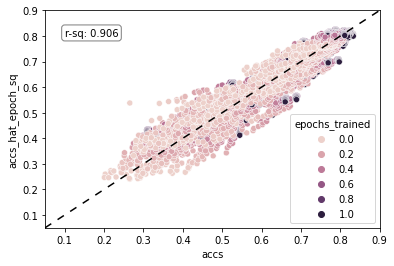

rsquare train:
0.9058901486557329
0.9057446779456996
val avg loss:
0.0019466195896710367


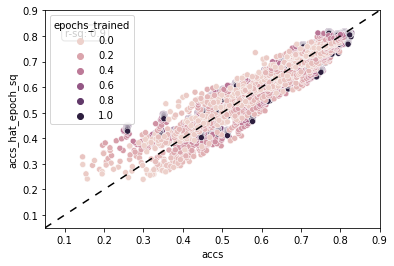

rsquare val:
0.9001373201828333
0.8998280839736554


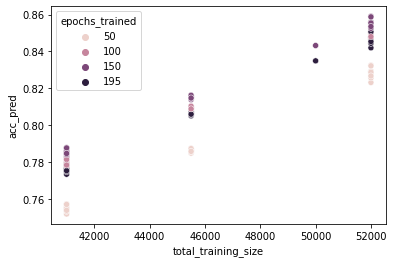

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred,accs_hat_classes_arctan_epoch_artan
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.834884,0.831677
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.843187,0.828367
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.807510,0.825484
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.816255,0.822182
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.810355,0.814357
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.787409,0.785554
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.806674,0.825277
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.815434,0.821975
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.809525,0.814150
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.786540,0.785350


In [31]:
def func_powerlaw(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epochs_sq:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c

np.random.seed(seed=421324576)
n_p = 15
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    print(params)
    param_names = ["a", "b", "c"]
    param_names = param_names + classes + ["epoch", "epoch**2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_epoch_sq"
    y_hat = func_powerlaw(xdata, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results.accs, results[y_hat_name])) * (xdata.shape[1] - 1) / (xdata.shape[1] - n_p - 1))
    # val data:
    y_val_hat = func_powerlaw(xdata_val, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results_val.accs, results_val[y_hat_name])) * (xdata_val.shape[1] - 1) / (xdata_val.shape[1] - n_p - 1))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))



# Adding an intercept to the linear combination (keeping the squared epoch):

C:\Users\tmueh\AppData\Local\Temp\ipykernel_7124\3781602169.py:13: RuntimeWarning: invalid value encountered in power
  return a + ((d_int + d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c


param_name,a,b,c,intercept,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch**2
param_value,-10.0,0.035601,9.627888,4.195716,2.715293,2.187339,2.137987,1.185696,2.187501,1.962301,2.078077,2.681066,1.606965,1.752977,9.291529,-6.616329


\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
param\_name &      a &    b &    c &  intercept &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch**2 \\
\midrule
param\_value & -10.00 & 0.04 & 9.63 &       4.20 &   2.72 & 2.19 &  2.14 & 1.19 &  2.19 & 1.96 &  2.08 &   2.68 &  1.61 &   1.75 &   9.29 &     -6.62 \\
\bottomrule
\end{tabular}

train avg loss:
0.0017965023650986195


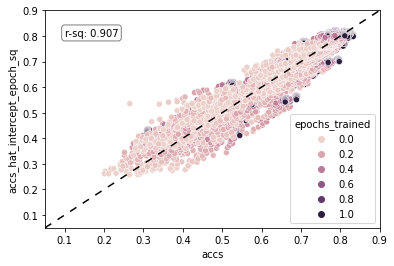

rsquare train:
0.9066843375692096
val avg loss:
0.0019363409516635688


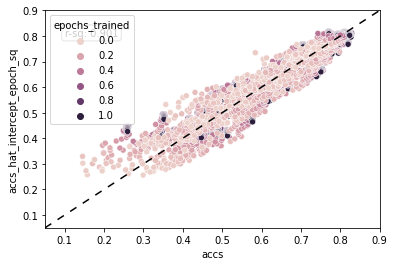

rsquare val:
0.9006646200937881


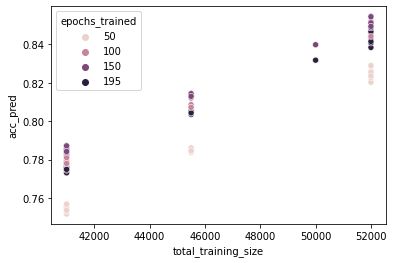

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred,accs_hat_classes_arctan_epoch_artan
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.831785,0.831677
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.839818,0.828367
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.805875,0.825484
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.814441,0.822182
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.808716,0.814357
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.786203,0.785554
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.805072,0.825277
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.813655,0.821975
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.807919,0.814150
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.785359,0.785350


In [32]:
def func_powerlaw(x, a: float, b: float, c: float, d_int:float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epochs_sq:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d_int + d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c

np.random.seed(seed=91240912)
p0 = np.random.uniform(low=0, high=1, size = 16)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "intercept"]
    param_names = param_names + classes + ["epoch", "epoch**2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_intercept_epoch_sq"
    y_hat = func_powerlaw(xdata, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

# using all epochs, but just overall training dataset size:

param_name,a,b,c,total_n,epoch
param_value,0.291629,0.61062,0.804609,0.073667,0.4379


\begin{tabular}{lrrrrr}
\toprule
param\_name &    a &    b &    c &  total\_n &  epoch \\
\midrule
param\_value & 0.29 & 0.61 & 0.80 &     0.07 &   0.44 \\
\bottomrule
\end{tabular}

train avg loss:
0.0021267406650214886


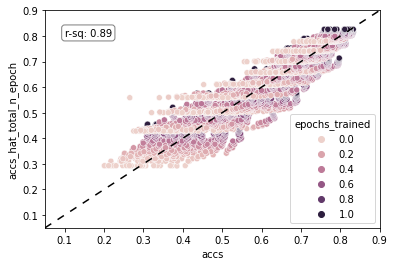

rsquare train:
0.8895307805708982
val avg loss:
0.002019111592293823


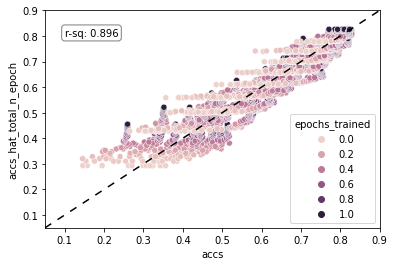

rsquare val:
0.8964184396754981


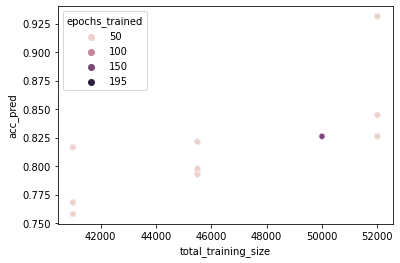

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred,accs_hat_classes_arctan_epoch_artan
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.826055,0.831677
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.826055,0.828367
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.797619,0.825484
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.797619,0.822182
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.797619,0.814357
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.797619,0.785554
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.821330,0.825277
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.821330,0.821975
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.821330,0.814150
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.821330,0.785350


In [33]:
def func_powerlaw(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float) -> float:
    x_total_n = x[0]
    x_epoch = x[1]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch)**b) * c

np.random.seed(seed=434213523)

p0 = np.random.uniform(low=0, high=1, size = 5)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_total_n_epoch, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "total_n", "epoch"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat = func_powerlaw(xdata_total_n_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n_epoch"
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_total_n_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

param_name,a,b,c,total_n,epoch,epoch_sq
param_value,0.327061,0.798975,0.764739,0.092497,0.663331,-0.170256


\begin{tabular}{lrrrrrr}
\toprule
param\_name &         a &         b &         c &   total\_n &     epoch &  epoch\_sq \\
\midrule
param\_value &  0.327061 &  0.798975 &  0.764739 &  0.092497 &  0.663331 & -0.170256 \\
\bottomrule
\end{tabular}

train avg loss:
0.002090376283225788


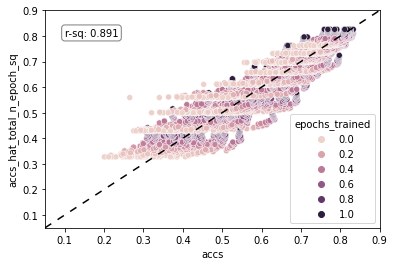

rsquare train:
0.8914196544416352
val avg loss:
0.0019930076848116095


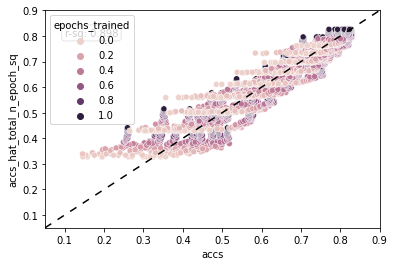

rsquare val:
0.8977575848113558


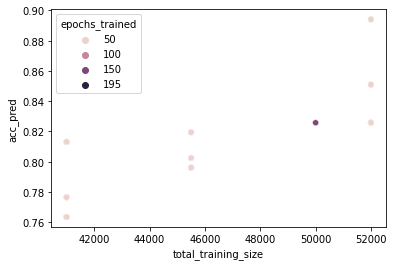

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred,accs_hat_classes_arctan_epoch_artan
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.825791,0.831677
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.825791,0.828367
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.802515,0.825484
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.802515,0.822182
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.802515,0.814357
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.802515,0.785554
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.819469,0.825277
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.819469,0.821975
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.819469,0.814150
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.819469,0.785350


In [34]:
def func_powerlaw(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float, d_epochs_sq:float) -> float:
    x_total_n = x[0]
    x_epoch = x[1]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch + d_epochs_sq*x_epoch**2)**b) * c

np.random.seed(seed=959486)
p0 = np.random.uniform(low=0, high=1, size = 6)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_total_n_epoch, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "total_n", "epoch", "epoch_sq"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex())
    y_hat = func_powerlaw(xdata_total_n_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n_epoch_sq"
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_total_n_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

### Using the arctan trick also for the total_n model:

C:\Users\tmueh\AppData\Local\Temp\ipykernel_7124\1161056672.py:4: RuntimeWarning: invalid value encountered in power
  return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c


param_name,a,b,c,total_n,total_n_2,epoch,epoch_2
param_value,0.25865,0.796769,0.431934,0.199747,7.958617,1.287873,1.094062


\begin{tabular}{lrrrrrrr}
\toprule
param\_name &        a &         b &         c &   total\_n &  total\_n\_2 &     epoch &   epoch\_2 \\
\midrule
param\_value &  0.25865 &  0.796769 &  0.431934 &  0.199747 &   7.958617 &  1.287873 &  1.094062 \\
\bottomrule
\end{tabular}

train avg loss:
0.001844351071135957


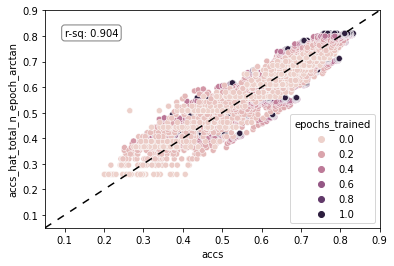

rsquare train:
0.904198933827431
0.9041298844593083
val avg loss:
0.001752802875364697


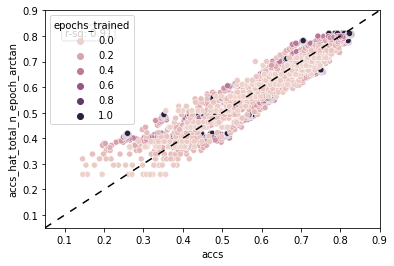

rsquare val:
0.9100802266380489
0.9099504990177822


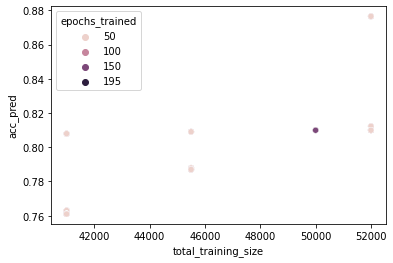

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred,accs_hat_classes_arctan_epoch_artan
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.809923,0.831677
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.809923,0.828367
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.787881,0.825484
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.787881,0.822182
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.787881,0.814357
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.787881,0.785554
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.809034,0.825277
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.809034,0.821975
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.809034,0.814150
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.809034,0.785350


In [35]:
def func_powerlaw(x, a: float, b: float, c: float, d_total_n:float, d_total_n_2:float, d_epochs:float, d_epochs_2:float) -> float:
    x_total_n = x[0]
    x_epoch = x[1]
    return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c

np.random.seed(seed=92548)
n_p = 7
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_total_n_epoch, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "total_n", "total_n_2", "epoch", "epoch_2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex())
    y_hat = func_powerlaw(xdata_total_n_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n_epoch_arctan"
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results.accs, results[y_hat_name])) * (xdata_total_n_epoch.shape[1] - 1) / (xdata_total_n_epoch.shape[1] - n_p - 1))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_total_n_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results_val.accs, results_val[y_hat_name])) * (xdata_val.shape[1] - 1) / (xdata_val.shape[1] - n_p - 1))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

# restricting to last epoch:

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
param_value,0.137152,0.412225,0.368004,0.673512,0.507746,0.518404,0.249813,0.509014,0.458538,0.485162,0.611853,0.363204,0.419


train avg loss:
0.0016495515062348407


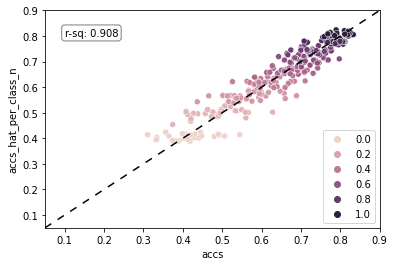

rsquare train:
0.9075660664703544
val avg loss:
0.0018398750176514243


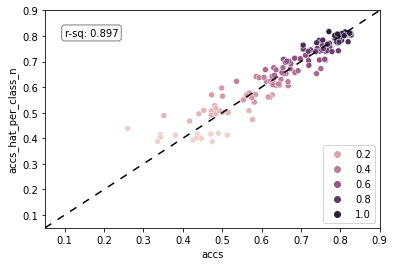

rsquare val:
0.8972813359301713


In [36]:
def func_powerlaw(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9)**b) * c


p0 = np.random.uniform(low=0, high=1, size = 13)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_last_epoch, y_last_epoch, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c"] + classes
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    y_hat = func_powerlaw(xdata_last_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y_last_epoch)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_per_class_n"
    results_last_epoch[y_hat_name] = y_hat
    sns.scatterplot(data = results_last_epoch, x="accs", y = y_hat_name, hue = "total_training_size")
    plt.legend(loc="lower right")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_last_epoch.accs, results_last_epoch[y_hat_name]), 3)}", bbox=props)
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results_last_epoch.accs, results_last_epoch[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_last_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val_last_epoch)**2).mean())
    # dataframe for plotting:
    results_val_last_epoch[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val_last_epoch, x="accs", y = y_hat_name, hue = "total_training_size")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.legend(loc="lower right")
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val_last_epoch.accs, results_val_last_epoch[y_hat_name]), 3)}", bbox=props)
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val_last_epoch.accs, results_val_last_epoch[y_hat_name]))

# Fitting with total_n, only last epoch:

param_name,a,b,c
param_value,0.408111,0.704068,0.408313


train avg loss:
0.0018095482212023444


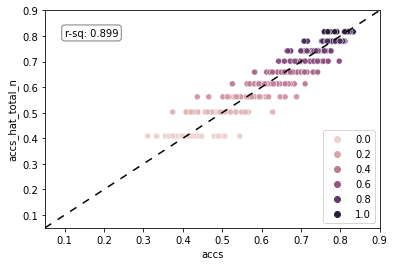

rsquare train:
0.8986005230118027
val avg loss:
0.0017054827566673426


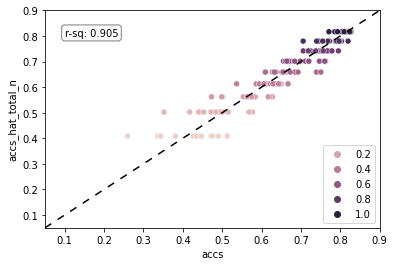

rsquare val:
0.9047843420458965


In [37]:
def func_powerlaw(x, a: float, b: float, c: float) -> float:
    x0 = x[0]
    return a + (x0**b) * c

p0 = np.random.uniform(low=0, high=1, size = 3)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_last_epoch_total_n, y_last_epoch, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    y_hat = func_powerlaw(xdata_last_epoch_total_n, *params)
    print("train avg loss:")
    print(((y_hat - y_last_epoch)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n"
    results_last_epoch[y_hat_name] = y_hat
    sns.scatterplot(data = results_last_epoch, x="accs", y = y_hat_name, hue = "total_training_size")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_last_epoch.accs, results_last_epoch[y_hat_name]), 3)}", bbox=props)
    plt.legend(loc="lower right")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results_last_epoch.accs, results_last_epoch[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_last_epoch_total_n, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val_last_epoch)**2).mean())
    # dataframe for plotting:
    results_val_last_epoch[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val_last_epoch, x="accs", y = y_hat_name, hue = "total_training_size")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val_last_epoch.accs, results_val_last_epoch[y_hat_name]), 3)}", bbox=props)
    plt.legend(loc="lower right")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val_last_epoch.accs, results_val_last_epoch[y_hat_name]))